# Datensatz zum Training und Testen vorbereiten

In [1]:
folder = "imagenette2_320px/"

import torch
from torchvision import datasets, transforms

# Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()    
])

# Trainings- und Testdatensatz vorbereiten
train_dataset = datasets.ImageFolder(root=f"{folder}/train",
                                     transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=32,
                                           shuffle=True)

test_dataset = datasets.ImageFolder(root=f"{folder}/val",
                                    transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=32,
                                          shuffle=False)

In [2]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 9503
    Root location: imagenette2_320px//train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [3]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 3925
    Root location: imagenette2_320px//val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

# Anzahl der Batches pro Epoche anzeigen

In [4]:
nr_batches = 0
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    nr_batches += 1
print("nr_batches", nr_batches)

torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([3

In [5]:
len(train_dataset)

9503

In [8]:
len(train_loader)

297

In [9]:
train_loader.batch_size

32

In [10]:
len(train_dataset) / train_loader.batch_size

296.96875

In [11]:
9501 % 32

29

In [12]:
29/32

0.90625

# CNN-Modell in PyTorch definieren

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3,  out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1   = nn.Linear(64*28*28, 512)
        self.fc2   = nn.Linear(512, 10) # 10 Klassen

    def forward(self, x):

        # Merkmalshierarchie
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        # Übergang zum MLP
        x = F.flatten(x)
        # MLP
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # absichtlich: keine Relu hier!  

        return x
        

In [14]:
model = SimpleCNN()
model

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

# Alternative Definition des CNN-Modells ohne `functional`-Modul 

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3,  out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.relu3 = nn.ReLU()

        self.flatten1 = nn.Flatten()
        
        self.fc1   = nn.Linear(64*28*28, 512)
        self.relu4 = nn.ReLU()
        self.fc2   = nn.Linear(512, 10) # 10 Klassen

    def forward(self, x):

        # Merkmalshierarchie
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))

        # Übergang zum MLP
        x = self.flatten1(x)
        # MLP
        x = self.relu4(self.fc1(x))
        x = self.fc2(x) # absichtlich: keine Relu hier!  

        return x
        

In [16]:
model = SimpleCNN()
model

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu3): ReLU()
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [17]:
!pip install torchsummary

In [18]:
from torchsummary import summary
summary(model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
          Flatten-10                [-1, 50176]               0
           Linear-11                  [-1, 512]      25,690,624
             ReLU-12                  [-1, 512]               0
           Linear-13                   [-1, 10]           5,130
Total params: 25,719,338
Trainable para

# Automatische Ermittelung der Zahl 64x28x28

In [ ]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,  out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)       
        self.pool2 = nn.MaxPool2d(2)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.relu3 = nn.ReLU()
        
        self.flatten = nn.Flatten()
        
        # Benutzen Sie einen Dummy-Eingabedatensatz, um die Größe automatisch zu ermitteln
        with torch.no_grad():
            self._initialize_fc_layers(torch.rand(1, 3, 224, 224))

    def _initialize_fc_layers(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        print("x.size=",x.size())
        n_size = x.size(1)
        print("n_size=",n_size)
        self.fc1   = nn.Linear(n_size, 512)
        self.relu4 = nn.ReLU()
        self.fc2   = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))

        # Übergang zum MLP
        x = self.flatten(x)

        # MLP        
        x = self.relu4(self.fc1(x))        
        x = self.fc2(x)

        # Output-Tensor zurückliefern
        return x

model = SimpleCNN()
model

In [19]:
from torchsummary import summary
summary(model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
          Flatten-10                [-1, 50176]               0
           Linear-11                  [-1, 512]      25,690,624
             ReLU-12                  [-1, 512]               0
           Linear-13                   [-1, 10]           5,130
Total params: 25,719,338
Trainable para

# CNN erstellen und auf der CPU trainieren

In [20]:
import torch.optim as optim

model = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2
model.train()

for epoch in range(1,num_epochs+1):
    print(f"Trainings-Epoche: {epoch}/{num_epochs}")

    batch_nr = 1
    for images, labels in train_loader:
        if batch_nr % 1 == 0:
            print(f"\tBatch: {batch_nr}")
        outputs = model(images)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_nr += 1

        if batch_nr==10:
            break

Trainings-Epoche: 1/2
	Batch: 1
	Batch: 2
	Batch: 3
	Batch: 4
	Batch: 5
	Batch: 6
	Batch: 7
	Batch: 8
	Batch: 9
Trainings-Epoche: 2/2
	Batch: 1
	Batch: 2
	Batch: 3
	Batch: 4
	Batch: 5
	Batch: 6
	Batch: 7
	Batch: 8
	Batch: 9


# Ist eine GPU verfügbar?

In [21]:
torch.cuda.is_available()

True

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
device

device(type='cuda')

# Jetzt geht es auf die GPU

Trainings-Epoche: 1/2
	Batch: 25
	Batch: 50
	Batch: 75
	Batch: 100
	Batch: 125
	Batch: 150
	Batch: 175
	Batch: 200
	Batch: 225
	Batch: 250
	Batch: 275
Trainings-Epoche: 2/2
	Batch: 25
	Batch: 50
	Batch: 75
	Batch: 100
	Batch: 125
	Batch: 150
	Batch: 175
	Batch: 200
	Batch: 225
	Batch: 250
	Batch: 275


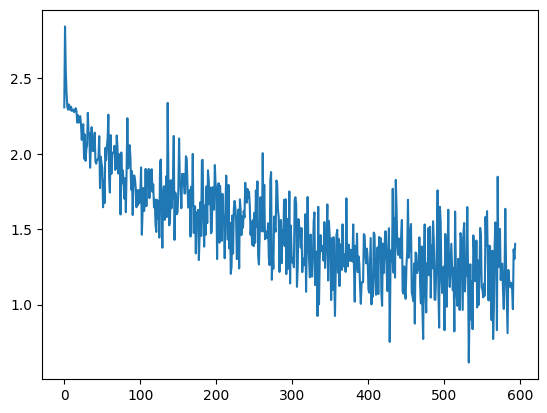

In [24]:
import torch.optim as optim

model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2
model.train()

losses = []

for epoch in range(1,num_epochs+1):
    print(f"Trainings-Epoche: {epoch}/{num_epochs}")

    batch_nr = 1
    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)
        
        if batch_nr % 25 == 0:
            print(f"\tBatch: {batch_nr}")
        outputs = model(images)

        loss = criterion(outputs, labels)
        losses.append( loss.item() )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_nr += 1

import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

# Modellgüte bestimmen

I will import the newest version of cnnexps!
Willkommen zum cnnexps Modul! V3.0
x.size= torch.Size([1, 50176])
n_size= 50176
Trainings-Epoche: 1/15
	Batch: 25
	Batch: 50
	Batch: 75
	Batch: 100
	Batch: 125
	Batch: 150
	Batch: 175
	Batch: 200
	Batch: 225
	Batch: 250
	Batch: 275
Epoch 1/15, TestAcc: 50.7261%
Duration: 37.63 seconds
Trainings-Epoche: 2/15
	Batch: 25
	Batch: 50
	Batch: 75
	Batch: 100
	Batch: 125
	Batch: 150
	Batch: 175
	Batch: 200
	Batch: 225
	Batch: 250
	Batch: 275
Epoch 2/15, TestAcc: 55.2611%
Duration: 42.27 seconds
Trainings-Epoche: 3/15
	Batch: 25
	Batch: 50
	Batch: 75
	Batch: 100
	Batch: 125
	Batch: 150
	Batch: 175
	Batch: 200
	Batch: 225
	Batch: 250
	Batch: 275
Epoch 3/15, TestAcc: 63.2866%
Duration: 38.72 seconds
Trainings-Epoche: 4/15
	Batch: 25
	Batch: 50
	Batch: 75
	Batch: 100
	Batch: 125
	Batch: 150
	Batch: 175
	Batch: 200
	Batch: 225
	Batch: 250
	Batch: 275
Epoch 4/15, TestAcc: 62.8535%
Duration: 42.52 seconds
Trainings-Epoche: 5/15
	Batch: 25
	Batch: 50
	Batch

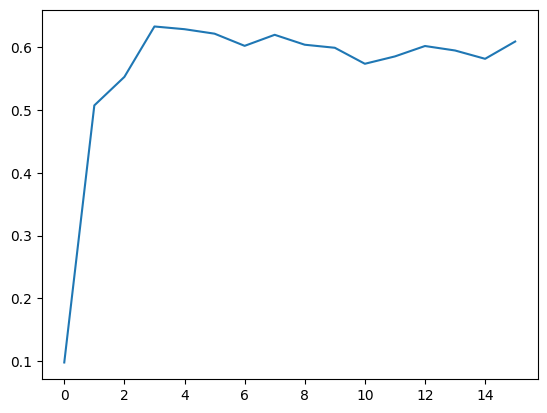

In [4]:
import sys
already_imported = "cnnexps" in sys.modules.keys()
if already_imported:
    print("I will import the newest version of cnnexps!")
    import importlib
    importlib.reload(cnnexps)
else:
    print("I will import cnnexps for the 1st time!")
    import cnnexps

# 1. Datensatz einlesen
folder = "imagenette2_320px/"
train_loader, test_loader = cnnexps.prepare_dataset( folder )

# 2. CNN erstellen
model = cnnexps.SimpleCNN()

# 3. Training auf CPU oder GPU?
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 4. Training starten
cnnexps.train_model(model, device, train_loader, test_loader, num_epochs=15)

In [15]:
model.eval()
correct = 0
total = 0
with torch.no_grad(): # Deaktiviert Gradientenberechnung
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _,predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        break

In [16]:
images.shape

torch.Size([32, 3, 224, 224])

In [19]:
labels.shape

torch.Size([32])

In [20]:
outputs.shape

torch.Size([32, 10])

In [25]:
outputs[1]

tensor([ 1.5321, -2.5936,  0.3195,  1.0115, -1.6463, -2.4563,  2.3792, -0.5134,
        -0.8992, -0.6340], device='cuda:0')

In [24]:
_,predicted = torch.max(outputs.data, 1)

torch.return_types.max(
values=tensor([1.2554, 2.3792, 3.9600, 4.2190, 1.7142, 1.4900, 1.9030, 4.8152, 4.2715,
        1.0438, 1.2091, 2.7013, 1.1011, 3.7652, 4.6468, 2.4406, 1.7915, 1.0326,
        2.7457, 2.6194, 3.8269, 3.5224, 0.5480, 0.7525, 1.5135, 3.0796, 1.6840,
        2.0150, 3.7822, 0.4135, 4.6220, 1.4249], device='cuda:0'),
indices=tensor([3, 6, 0, 0, 8, 5, 8, 0, 8, 0, 0, 1, 5, 0, 0, 0, 4, 0, 1, 8, 0, 6, 0, 3,
        7, 0, 0, 1, 0, 2, 0, 8], device='cuda:0'))

In [26]:
predicted

tensor([3, 6, 0, 0, 8, 5, 8, 0, 8, 0, 0, 1, 5, 0, 0, 0, 4, 0, 1, 8, 0, 6, 0, 3,
        7, 0, 0, 1, 0, 2, 0, 8], device='cuda:0')

In [27]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [28]:
predicted == labels

tensor([False, False,  True,  True, False, False, False,  True, False,  True,
         True, False, False,  True,  True,  True, False,  True, False, False,
         True, False,  True, False, False,  True,  True, False,  True, False,
         True, False], device='cuda:0')

In [32]:
(predicted == labels).sum().item()

15

# Exkurs: `torch.max`

In [14]:
t1 = torch.tensor([[1,2,3,4],
                   [5,10,7,8],
                   [9,6,11,12]])

In [8]:
type(t1)

torch.Tensor

In [16]:
t1

tensor([[ 1,  2,  3,  4],
        [ 5, 10,  7,  8],
        [ 9,  6, 11, 12]])

In [15]:
t1.unsqueeze(0)

tensor([[[ 1,  2,  3,  4],
         [ 5, 10,  7,  8],
         [ 9,  6, 11, 12]]])

In [9]:
torch.max(t1,0)

torch.return_types.max(
values=tensor([ 9, 10, 11, 12]),
indices=tensor([2, 1, 2, 2]))

In [10]:
torch.max(t1,1)

torch.return_types.max(
values=tensor([ 4, 10, 12]),
indices=tensor([3, 1, 3]))

In [11]:
t1

tensor([[ 1,  2,  3,  4],
        [ 5, 10,  7,  8],
        [ 9,  6, 11, 12]])

In [13]:
t1.data

tensor([[ 1,  2,  3,  4],
        [ 5, 10,  7,  8],
        [ 9,  6, 11, 12]])

# Modell wiederherstellen und anwenden

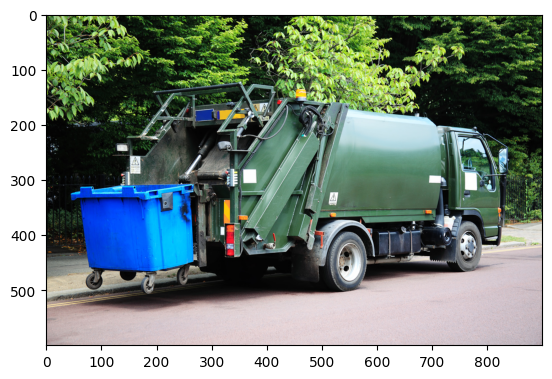

In [8]:
import cv2
folder = "/home/juebrauer/link_to_vcd/07_datasets/35_test_images_for_imagenette_models/"
fname = "garbagetruck01.jpg"
img = cv2.imread(folder + fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [9]:
import pickle
datei = open("models/model_0003.pkl", "rb")
model = pickle.load(datei)
test_accs = pickle.load(datei)
datei.close()

In [10]:
test_accs

[0.0980891719745223,
 0.5072611464968153,
 0.5526114649681528,
 0.6328662420382165]

In [21]:
from torchvision import transforms

def classify_image(img):

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()    
    ])

    img_tensor = transform(img).unsqueeze(0)

    img_tensor = img_tensor.to(device)

    model.eval()

    outputs = model(img_tensor)

    return outputs

In [22]:
type(img)

numpy.ndarray

In [23]:
img.shape

(600, 900, 3)

In [24]:
classify_image(img)

tensor([[-1.1808, -0.9145, -0.9051,  2.1965, -4.3584,  0.7531,  2.7072, -0.1787,
          0.0236, -2.9590]], device='cuda:0', grad_fn=<AddmmBackward0>)